In [1]:
import splat
import wisps
import matplotlib.pyplot as plt
from wisps.data_analysis import selection_criteria as sel_crt
from wisps.utils.tools import extrap1d
from wisps.simulations import selection_function as slf
import numpy as np
import pandas as pd

import matplotlib as mpl

mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

%matplotlib inline
#%%capture  output
import splat
import itertools

In [2]:
sf=pd.read_pickle(wisps.OUTPUT_FILES+'/selection_function.pkl') #the simulated spectral data
rf=pd.read_pickle(wisps.OUTPUT_FILES+'/random_forest_classifier.pkl') #the classifier 
min_max_scaler= pd.read_pickle(wisps.OUTPUT_FILES+'/min_max_scaler.pkl')#the min max scaler used to transform the data
indices_to_use= pd.read_pickle(wisps.OUTPUT_FILES+'/best_indices_to_use.pkl')

In [3]:
simulated_data=sf.data

In [4]:
#selection criteria
slc_crts=sel_crt.crts_from_file()

In [5]:
rf_features=['CH_4/H-Cont', 'CH_4/H_2O-1', 'CH_4/H_2O-2', 'CH_4/J-Cont',
       'H-cont/H_2O-1', 'H-cont/H_2O-2', 'H-cont/J-Cont', 'H_2O-1/J-Cont',
       'H_2O-2/H_2O-1', 'H_2O-2/J-Cont',  'spex_chi', 'snr2',
       'line_chi', 'f_test', 'x']
#features used by the classifier

#### Define a bunch of selection processes

In [6]:
#define a number of selectors 
#each selection should a column of zeros and ones corresponding
#to where objects were selected
#each selector input is the simulated df
def select_by_indices(df):
    #use spectral indices
    good_indices=[slc_crts[k] for k in indices_to_use.keys()]
    cands=[]
    for idx, k in zip(good_indices, indices_to_use.keys()):
        spt_range=indices_to_use[k][0]
        print (spt_range)
        bs=idx.shapes
        bx=[x for x in bs if x.shape_name==spt_range][0]
        df_to_use=wisps.Annotator.reformat_table(df[[idx.xkey, idx.ykey]])
        selec_indx_array=bx.select(df_to_use).index
        ls=df.iloc[selec_indx_array].Names
        cands.append(ls)
    
    merged = np.array(list(itertools.chain(*cands)))
    final_cands=np.unique(merged.flatten())
    return (df.Names.isin(final_cands))

def select_by_f_test(df):
    return df['f_test']>.5
    
def select_by_random_forest(df):
    #use the classification given by my rf classifier
    prblm_feats=['line_chi', 'spex_chi', 'H_2O-2/J-Cont', 'H-cont/J-Cont', 'H_2O-1/J-Cont', 'H-cont/H_2O-1', 'snr2', 'x']
    
    #apply logs to problematic features the same way I did on my classification
    df[prblm_feats]=df[prblm_feats].applymap(np.log10).replace(np.inf, np.nan).replace(-np.inf, np.nan).replace(np.nan, -999999.9)
    
    #scale the features 
    x=df[rf_features].replace(-np.inf, np.nan).replace(np.nan,  -999999.9).values
    
    #check for 15 columns
    print (x.shape)
    pred_set=min_max_scaler.transform(x)
    labels=rf.predict(pred_set)
    
    #return the predictions
    return labels

def select_by_snr(df):
    #use snr cutoff
    pass

#### Add missing features to the data

In [7]:
simulated_data.columns

Index(['cdf_snr', 'snr1', 'snr2', 'snr3', 'snr4', 'f', 'line_chi', 'spex_chi',
       'H_2O-1/J-Cont', 'H_2O-2/H_2O-1', 'H-cont/H_2O-1', 'CH_4/H_2O-1',
       'H_2O-2/J-Cont', 'H-cont/J-Cont', 'CH_4/J-Cont', 'H-cont/H_2O-2',
       'CH_4/H_2O-2', 'CH_4/H-Cont', 'spt', 'spectra', 'Names', 'selected'],
      dtype='object')

In [8]:
simulated_data=simulated_data.rename(columns={"f":"f_test"})

In [9]:
simulated_data['x']=simulated_data.spex_chi/simulated_data.line_chi

In [10]:
df=simulated_data

In [11]:
df['f_test_label']=select_by_f_test(df).apply(int)

In [12]:
df['rf_label']=select_by_random_forest(wisps.Annotator.reformat_table(df))

(6290, 15)


In [13]:
df['index_label']=select_by_indices(df).apply(int)

L0-L5
L5-T0
T0-T5
Y dwarfs
T5-T9
subdwarfs


In [14]:
df['idx_ft_label']=np.logical_and(df['index_label'].apply(bool), df['f_test_label'].apply(bool) ).apply(int)

In [19]:
df['idx_ml_label']=np.logical_and(df['index_label'].apply(bool), df['rf_label'].apply(bool) ).apply(int)

In [15]:
import seaborn as sns 
cmap=sns.light_palette((210, 90, 60), input="husl", as_cmap=True)

In [16]:
df['logsnr']=df['snr2'].apply(np.log10)

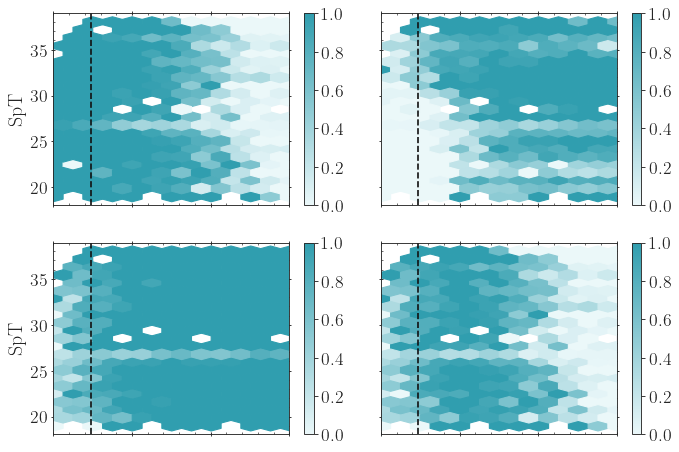

In [55]:
fig, ax=plt.subplots(ncols=2, nrows=2, figsize=(6*1.5, 4*1.5), sharex=True, sharey=True)
df.plot.hexbin(x='logsnr', y='spt', C='f_test_label', reduce_C_function=np.nanmean, gridsize=20, cmap=cmap, ax=ax[0][0])
df.plot.hexbin(x='logsnr', y='spt', C='rf_label', reduce_C_function=np.nanmean, gridsize=20, cmap=cmap, ax=ax[0][1])

df.plot.hexbin(x='logsnr', y='spt', C='index_label', reduce_C_function=np.nanmean, gridsize=20, cmap=cmap, ax=ax[1][0])
df.plot.hexbin(x='logsnr', y='spt', C='idx_ft_label', reduce_C_function=np.nanmean, gridsize=20, cmap=cmap, ax=ax[1][1])

#\\\\ax[0].scatter( sf.data.snr1.apply(np.log10), sf.data.spt, marker='+', color='#111111', alpha=.05)
#ax[1].scatter( sf.data.snr1.apply(np.log10), sf.data.spt, marker='+', color='#111111', alpha=.5)

for a in np.concatenate(ax):
    a.set_xlabel('log SNR')
    a.set_ylabel('SpT')
    a.axvline(np.log10(3), linestyle='--', color='#111111')
    #a.axvline(np.log10(10), linestyle='--', color='#111111', alpha=0.5)
    a.grid()
    a.set_xticks(np.arange(-1, 3, 0.1), minor=True)
    a.yaxis.set_ticks_position('both')
    a.xaxis.set_ticks_position('both')
    #a.set_yticks(np.arange(20, 40, 1), minor=True)
    a.tick_params(which='major',direction='inout')
    a.tick_params(which='minor', direction='in')
    
    a.set_xlim([0., 3.])
    
#ax[1].set_xlim([0.3, 4])
#ax[0].set_xlim([0.3, 4])
#ax[1].set_ylim([20, 38])
#ax[0].set_ylim([20, 38])
plt.minorticks_on()
plt.tight_layout()

#fig.axes[3].set_title(r'$\mathcal{S}$')
#fig.axes[2].set_title(r'$\mathcal{S}$')

plt.savefig(wisps.OUTPUT_FIGURES+'/selection_function_samples.pdf', bbox_inches='tight', dpi=200)

(0.3, 4.0)

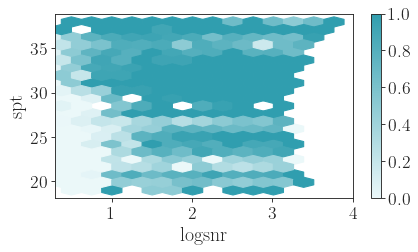

In [61]:
fig, ax=plt.subplots()
df.plot.hexbin(x='logsnr', y='spt', C='idx_ml_label', reduce_C_function=np.nanmean, gridsize=20, cmap=cmap, ax=ax)
#ax.scatter(df['logsnr'], y=df['spt'], marker='o',  facecolors='none',  edgecolors='#AAAAAA', alpha=0.3)
ax.set_xlim([0.3, 4.])

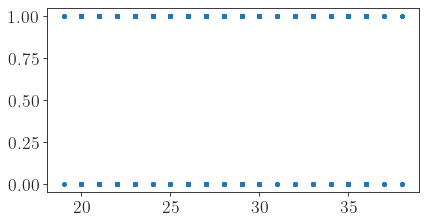

In [57]:
plt.plot(df.spt, df.f_test_label, '.')